# Прогноз оттока клиентов
Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Описание услуг**

**Оператор предоставляет два основных типа услуг:**
* Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
* Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

**Также доступны такие услуги:**
* Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
* Выделенная линия технической поддержки (TechSupport);
* Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
* Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Описание данных**

Данные состоят из файлов, полученных из разных источников:
* contract.csv — информация о договоре;
* personal.csv — персональные данные клиента;
* internet.csv — информация об интернет-услугах;
* phone.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.
Информация о договорах актуальна на 1 февраля 2020.

**Цель проекта** - создание прототипа модели, предсказывающей уход клиента.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder


from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve, confusion_matrix

from catboost import CatBoostClassifier

import tensorflow as tf
import keras
import os
from keras.models import Sequential
from keras.layers import Dense,Activation
from keras.optimizers import SGD
from keras import losses

from hyperopt import hp, fmin, tpe, rand, STATUS_OK, Trials
from hyperopt.pyll.base import scope
import shap
import phik

import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(130323)
RANDOM_STATE = 130323

## Загрузка и анализ данных
* Загрузим все таблицы
* Посмотрим на исходные таблицы по отдельности
* Объединим все таблицы в единый датасет по customerID
* Уберем явные дубликаты, если они есть
* Изменим типы столбцов, если нужно
* Выделим целевую переменную
* Посмотрим на распределение признаков (для категорильных долю каждой категории, для числовых построим гистограммы)
* Посмотрим есть ли пропуски, и что они из себя представляют.
* Посмотрим на распределение целевой переменной, наличие или отсутвие дисбалланса.
* Анализ корреляции признаков (для числовых признаков будем использовать коэффициент Пирсона, для категориальных Фика)
* На основе предыдущих пунктов составим портрет уходящих клиентов.

In [3]:
try:
    contracts = pd.read_csv('datasets/contract.csv', index_col='customerID')
    internet = pd.read_csv('datasets/internet.csv', index_col='customerID')
    personal = pd.read_csv('datasets/personal.csv', index_col='customerID')
    phone = pd.read_csv('datasets/phone.csv', index_col='customerID')
except FileNotFoundError: 
    contracts = pd.read_csv('/datasets/final_provider/contract.csv', index_col='customerID')
    internet = pd.read_csv('/datasets/final_provider/internet.csv', index_col='customerID')
    personal = pd.read_csv('/datasets/final_provider/personal.csv', index_col='customerID')
    phone = pd.read_csv('/datasets/final_provider/phone.csv', index_col='customerID')

In [4]:
def get_nan_info(data):
    display(pd.DataFrame(round(data.isna().mean()*100, 10)).style.background_gradient('coolwarm'))
    
def get_data_info(data):
    display(data.sample(5))
    display(data.info())
    display(data.describe(include='all'))
    get_nan_info(data)

In [5]:
get_data_info(contracts.join(personal))

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents
customerID,,,,,,,,,,,
6048-QBXKL,2019-12-01,No,Month-to-month,Yes,Credit card (automatic),56.55,118.25,Female,1,No,No
2911-WDXMV,2018-08-01,No,Month-to-month,Yes,Credit card (automatic),80.55,1406.65,Male,0,No,Yes
7010-BRBUU,2014-02-01,No,Two year,No,Credit card (automatic),24.10,1734.65,Male,0,Yes,Yes
9933-QRGTX,2015-02-01,No,Two year,Yes,Electronic check,97.20,5611.75,Female,0,Yes,No
4130-MZLCC,2019-09-01,No,Month-to-month,No,Bank transfer (automatic),50.55,244.75,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 918.3+ KB


None

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043,7043,7043,7043.000000,7043,7043,7043.000000,7043,7043
unique,77,5,3,2,4,NaN,6531,2,NaN,2,2
top,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,,Male,NaN,No,No
freq,366,5174,3875,4171,2365,NaN,11,3555,NaN,3641,4933
mean,NaN,NaN,NaN,NaN,NaN,64.761692,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,30.090047,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,18.250000,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,35.500000,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,70.350000,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,89.850000,NaN,NaN,0.000000,NaN,NaN


,0
BeginDate,0.000000
EndDate,0.000000
Type,0.000000
PaperlessBilling,0.000000
PaymentMethod,0.000000
MonthlyCharges,0.000000
TotalCharges,0.000000
gender,0.000000
SeniorCitizen,0.000000
Partner,0.000000


In [6]:
get_data_info(internet)

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
9488-HGMJH,Fiber optic,No,No,No,No,No,No
3672-YITQD,Fiber optic,No,No,No,No,No,Yes
5208-FVQKB,DSL,Yes,Yes,No,Yes,No,Yes
7503-MIOGA,DSL,Yes,Yes,Yes,Yes,Yes,Yes
5915-DGNVC,DSL,Yes,Yes,Yes,No,No,Yes


<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


None

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517
unique,2,2,2,2,2,2,2
top,Fiber optic,No,No,No,No,No,No
freq,3096,3498,3088,3095,3473,2810,2785


,0
InternetService,0.000000
OnlineSecurity,0.000000
OnlineBackup,0.000000
DeviceProtection,0.000000
TechSupport,0.000000
StreamingTV,0.000000
StreamingMovies,0.000000


In [7]:
get_data_info(phone)

,MultipleLines
customerID,
9812-GHVRI,Yes
4957-TREIR,No
0516-VRYBW,No
6185-TASNN,No
4585-HETAI,No


<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


None

,MultipleLines
count,6361
unique,2
top,No
freq,3390


,0
MultipleLines,0.000000


In [8]:
np.in1d(internet.index, phone.index).sum() / contracts.shape[0]

0.686497231293483

### Предварительные выводы:
* Не все клиенты пользуются одновременно услугами интернетом и стационарной телефонной связью.
* В данной выборке услуги интернета подключены у ~78% клиентов, телефон у ~90%?(данные с 2014 года, это странно), и то и другое у ~69%.
* В первом приближении пропуски в таблицах не обнаружены.

In [9]:
data = contracts.join(internet).join(personal).join(phone) # объединяем таблицы

In [10]:
get_data_info(data)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
6741-QRLUP,2014-11-01,No,Two year,Yes,Credit card (automatic),80.30,4995.35,DSL,Yes,Yes,Yes,Yes,No,Yes,Female,0,No,No,Yes
7625-XCQRH,2019-02-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,76.50,837.95,Fiber optic,No,No,No,No,No,No,Female,0,No,No,Yes
3407-QGWLG,2019-11-01,No,Month-to-month,Yes,Mailed check,20.05,75.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,No,Yes,No
5090-EMGTC,2015-03-01,No,Two year,Yes,Mailed check,100.05,6034.85,Fiber optic,No,Yes,No,Yes,Yes,Yes,Female,0,Yes,No,No
4057-FKCZK,2015-04-01,No,Two year,No,Bank transfer (automatic),82.50,4828.05,Fiber optic,No,No,No,No,Yes,No,Male,0,Yes,Yes,Yes


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
 7   InternetService   5517 non-null   object 
 8   OnlineSecurity    5517 non-null   object 
 9   OnlineBackup      5517 non-null   object 
 10  DeviceProtection  5517 non-null   object 
 11  TechSupport       5517 non-null   object 
 12  StreamingTV       5517 non-null   object 
 13  StreamingMovies   5517 non-null   object 
 14  gender            7043 non-null   object 
 15  SeniorCitizen     7043 non-null   int64  
 16  Partner           7043 non-null 

None

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
count,7043,7043,7043,7043,7043,7043.000000,7043,5517,5517,5517,5517,5517,5517,5517,7043,7043.000000,7043,7043,6361
unique,77,5,3,2,4,NaN,6531,2,2,2,2,2,2,2,2,NaN,2,2,2
top,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,,Fiber optic,No,No,No,No,No,No,Male,NaN,No,No,No
freq,366,5174,3875,4171,2365,NaN,11,3096,3498,3088,3095,3473,2810,2785,3555,NaN,3641,4933,3390
mean,NaN,NaN,NaN,NaN,NaN,64.761692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.162147,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,30.090047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.368612,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,18.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,35.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,70.350000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,89.850000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN


,0
BeginDate,0.000000
EndDate,0.000000
Type,0.000000
PaperlessBilling,0.000000
PaymentMethod,0.000000
MonthlyCharges,0.000000
TotalCharges,0.000000
InternetService,21.666903
OnlineSecurity,21.666903
OnlineBackup,21.666903


In [11]:
data.drop_duplicates(inplace=True) #удаляем явные дубликаты
data.shape #13 объктов удалено

(7030, 19)

In [12]:
#прербразуем тип данных в колонке TotalCharges
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce') 

In [13]:
get_nan_info(data) 

,0
BeginDate,0.000000
EndDate,0.000000
Type,0.000000
PaperlessBilling,0.000000
PaymentMethod,0.000000
MonthlyCharges,0.000000
TotalCharges,0.156472
InternetService,21.550498
OnlineSecurity,21.550498
OnlineBackup,21.550498


* Пропуски во всех колонках, кроме TotalCharges означают, что клиенты не пользуются этими услугами.
* Пропуски в TotalCharges связаны с тем, что эти клиенты заключили контракт в день выгрузки бызы (новые клиенты)
* Заполнять пропуски будем в зависимости от модели

In [14]:
data['Churn'] = np.where(data['EndDate'] != 'No', 1, 0) #выделяем целевую переменную

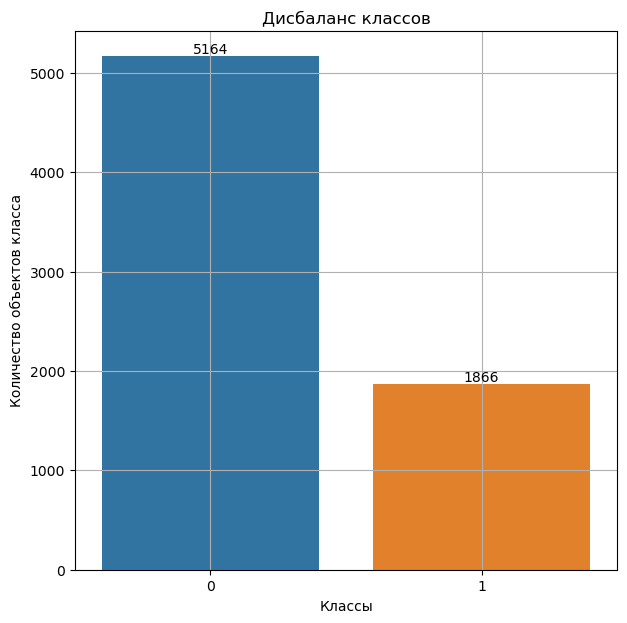

In [15]:
fig, ax= plt.subplots(figsize=(7,7))
sns.barplot(x = data['Churn'].unique(), y = data['Churn'].value_counts(), ax=ax, )
ax.set_title('Дисбаланс классов')
ax.set_xlabel('Классы')
ax.set_ylabel('Количество объектов класса')
ax.grid()
for i in ax.containers:
    ax.bar_label(i,)

* Дисбаланс классов существенный, примерно 1/3.
* Для корректного обучения и предсказания моделей это соотношение и количество объектов класса 1 не критичное.
* Дополнительно будем применять стратификацию при разбиении на тестовую/обучающую выборки и при кросс-валидации, а также посмотрим на изменения метрики при применении встроенных в библиотеки моделей методов борьбы с дисбалансом.

In [16]:
num_cols = [
    'Period',
    'MonthlyCharges',
    'TotalCharges'
]
cat_cols = [
    'Type', 
    'PaperlessBilling', 
    'PaymentMethod', 
    'InternetService', 
    'OnlineSecurity',
    'OnlineBackup', 
    'DeviceProtection', 
    'TechSupport', 
    'StreamingTV',
    'StreamingMovies', 
    'gender', 
    'SeniorCitizen', 
    'Partner', 
    'Dependents',
    'MultipleLines'
]
feature_cols = num_cols + cat_cols
target_col = 'Churn'

### Распределение категориальных признаков

In [17]:
def show_pie(data):
    fig, axes = plt.subplots(5, 3, figsize=(15, 20))
    for ax, col in zip(axes.flatten(), data[cat_cols]):
        ax.set_title(col)
        ax.pie(data[col].value_counts(), 
               labels = data[col].value_counts().index, 
               autopct="%1.2f%%") 

In [18]:
data['EndDate'].replace('No', '2020-02-01 00:00:00', inplace=True)
data['Period'] = (data['EndDate'].astype('datetime64') - data['BeginDate'].astype('datetime64')).apply(lambda x: str(x).split()[0]).astype('int64')

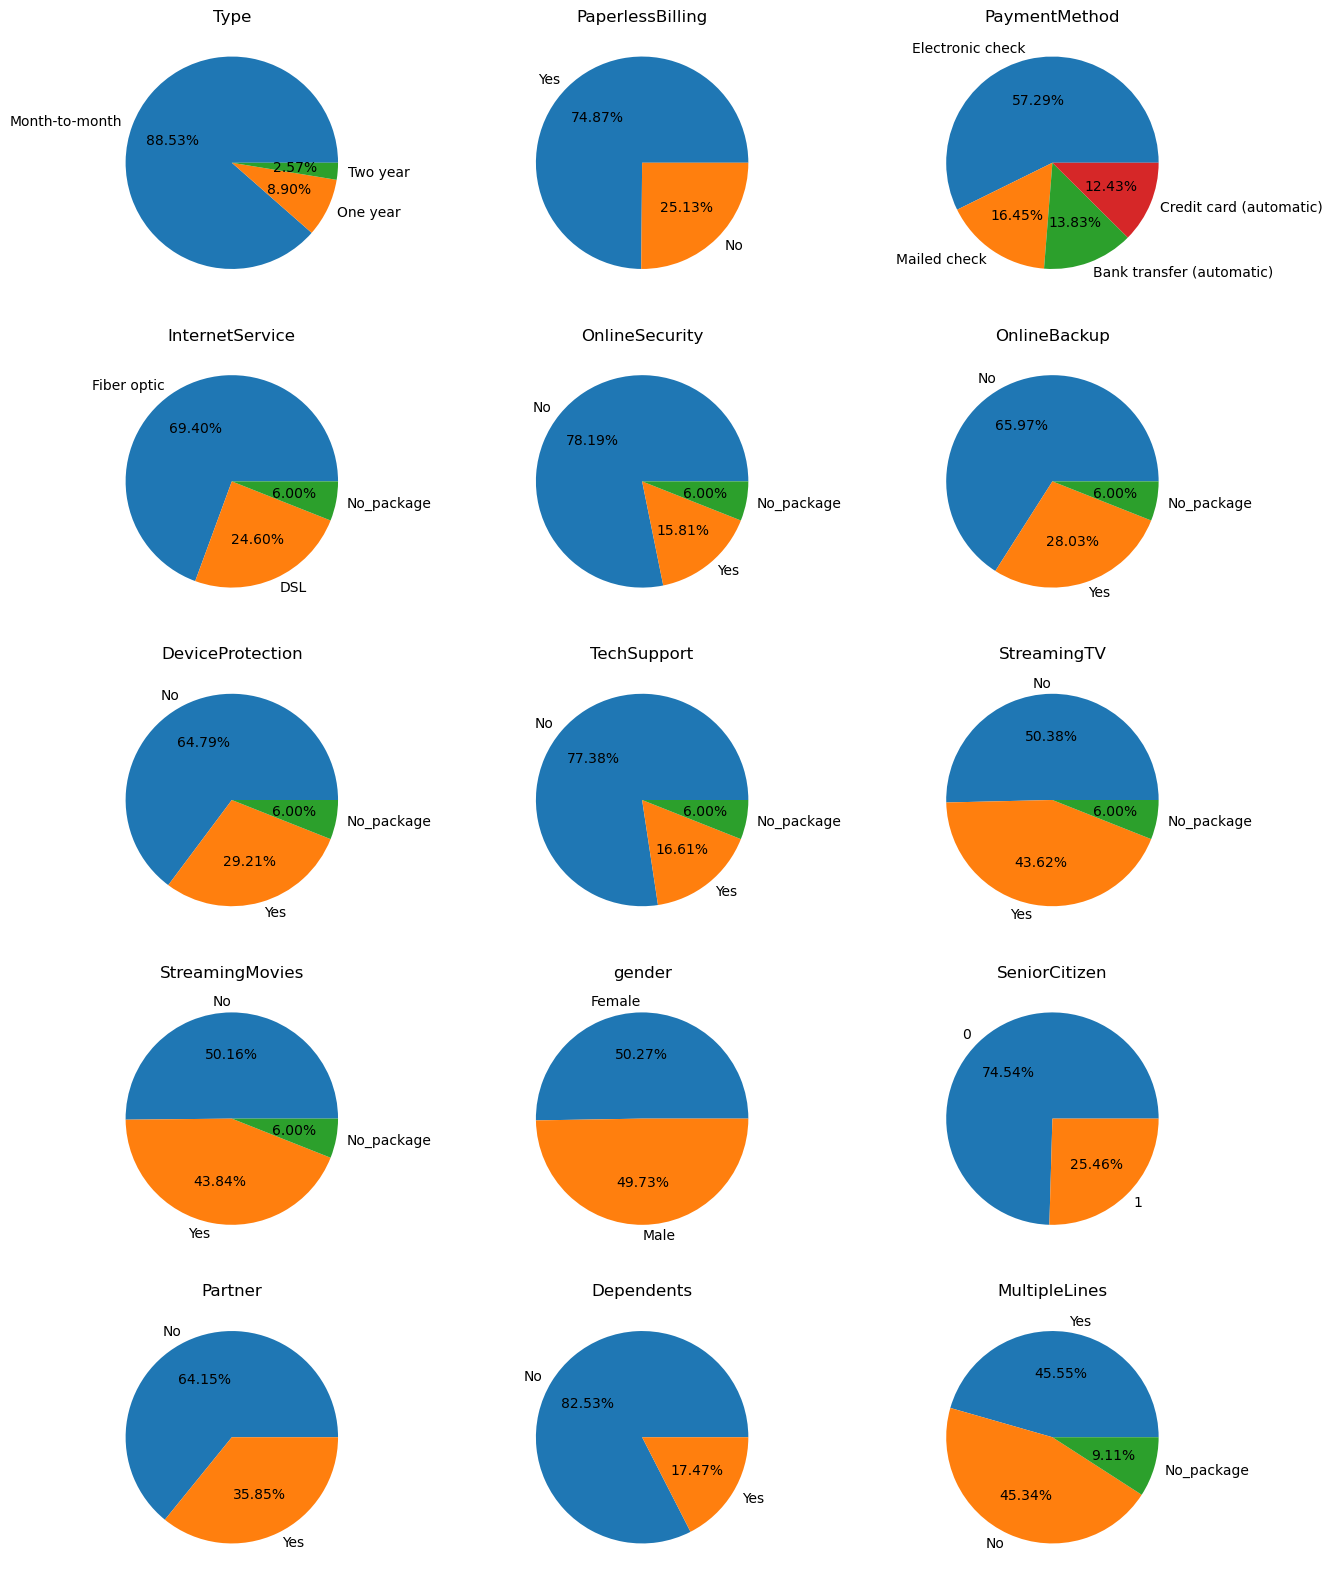

In [19]:
show_pie(data[data[target_col]==1].fillna('No_package'))

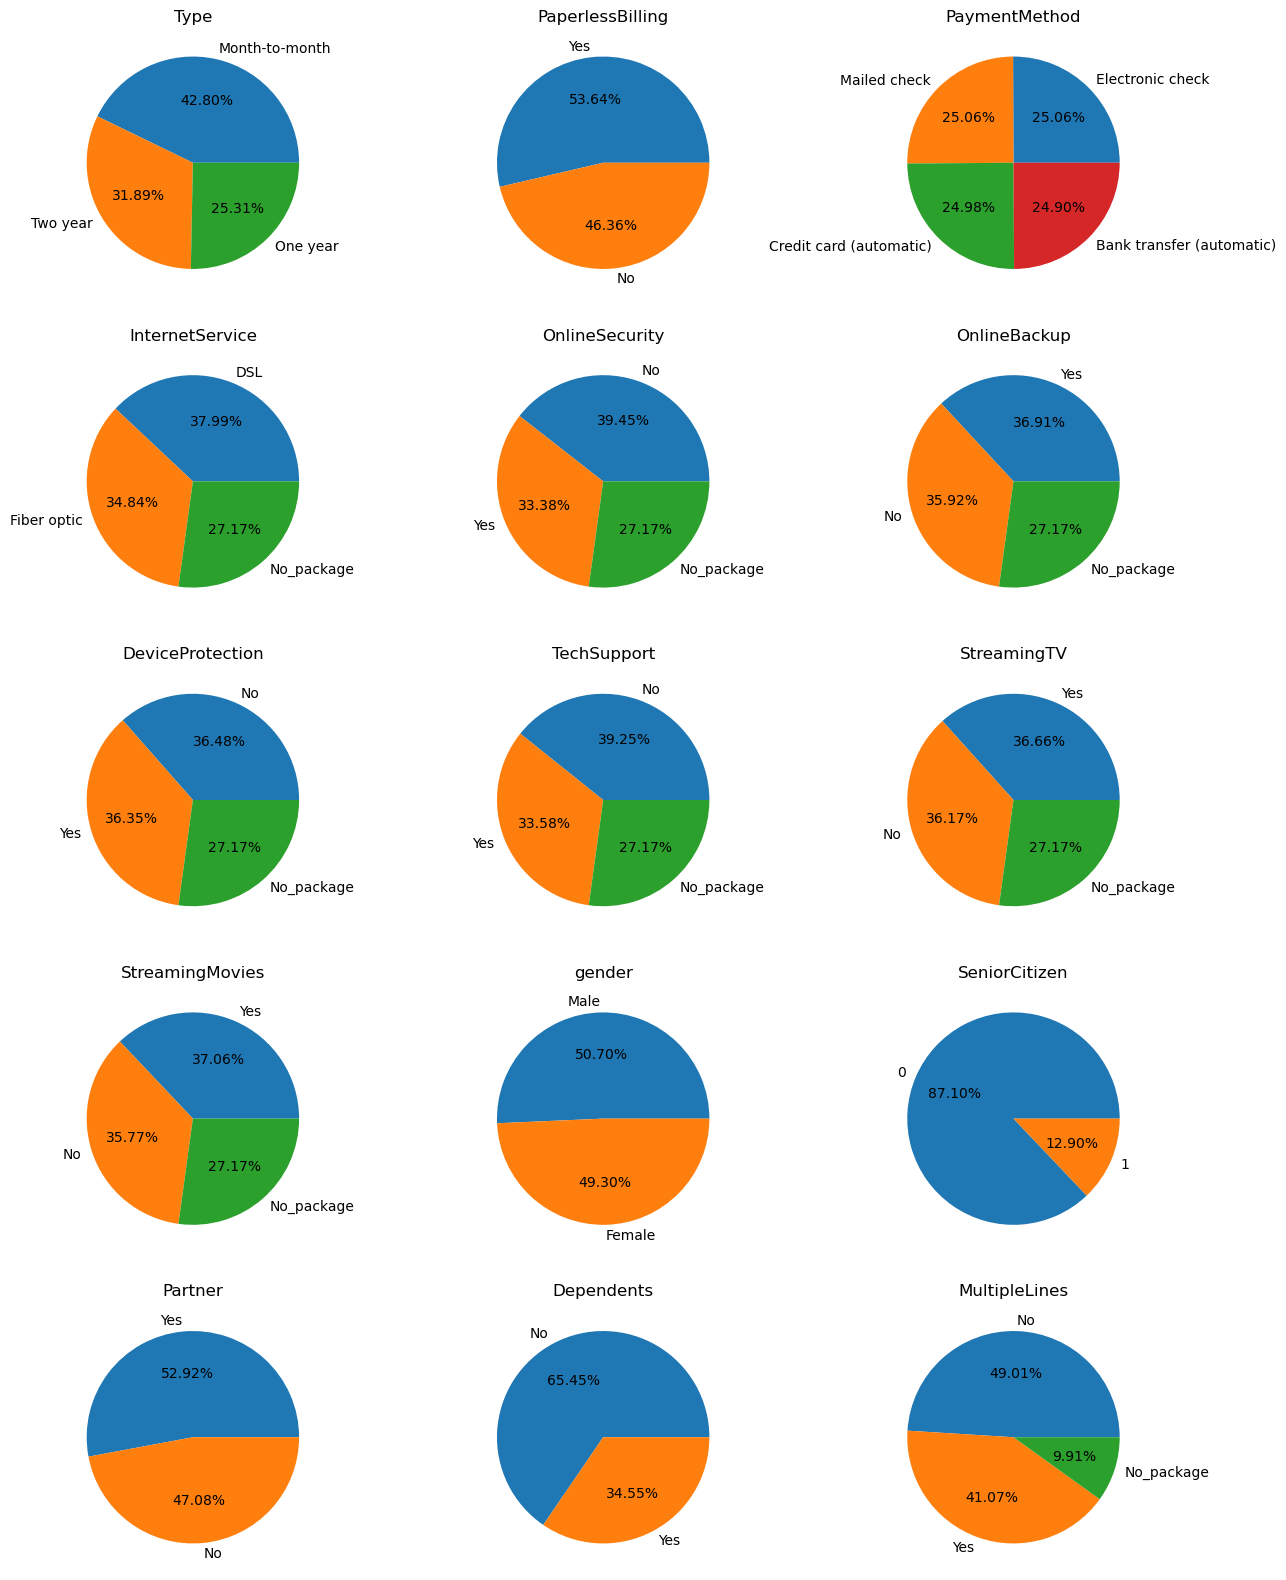

In [20]:
show_pie(data[data[target_col]==0].fillna('No_package'))

### Распределение численных признаков

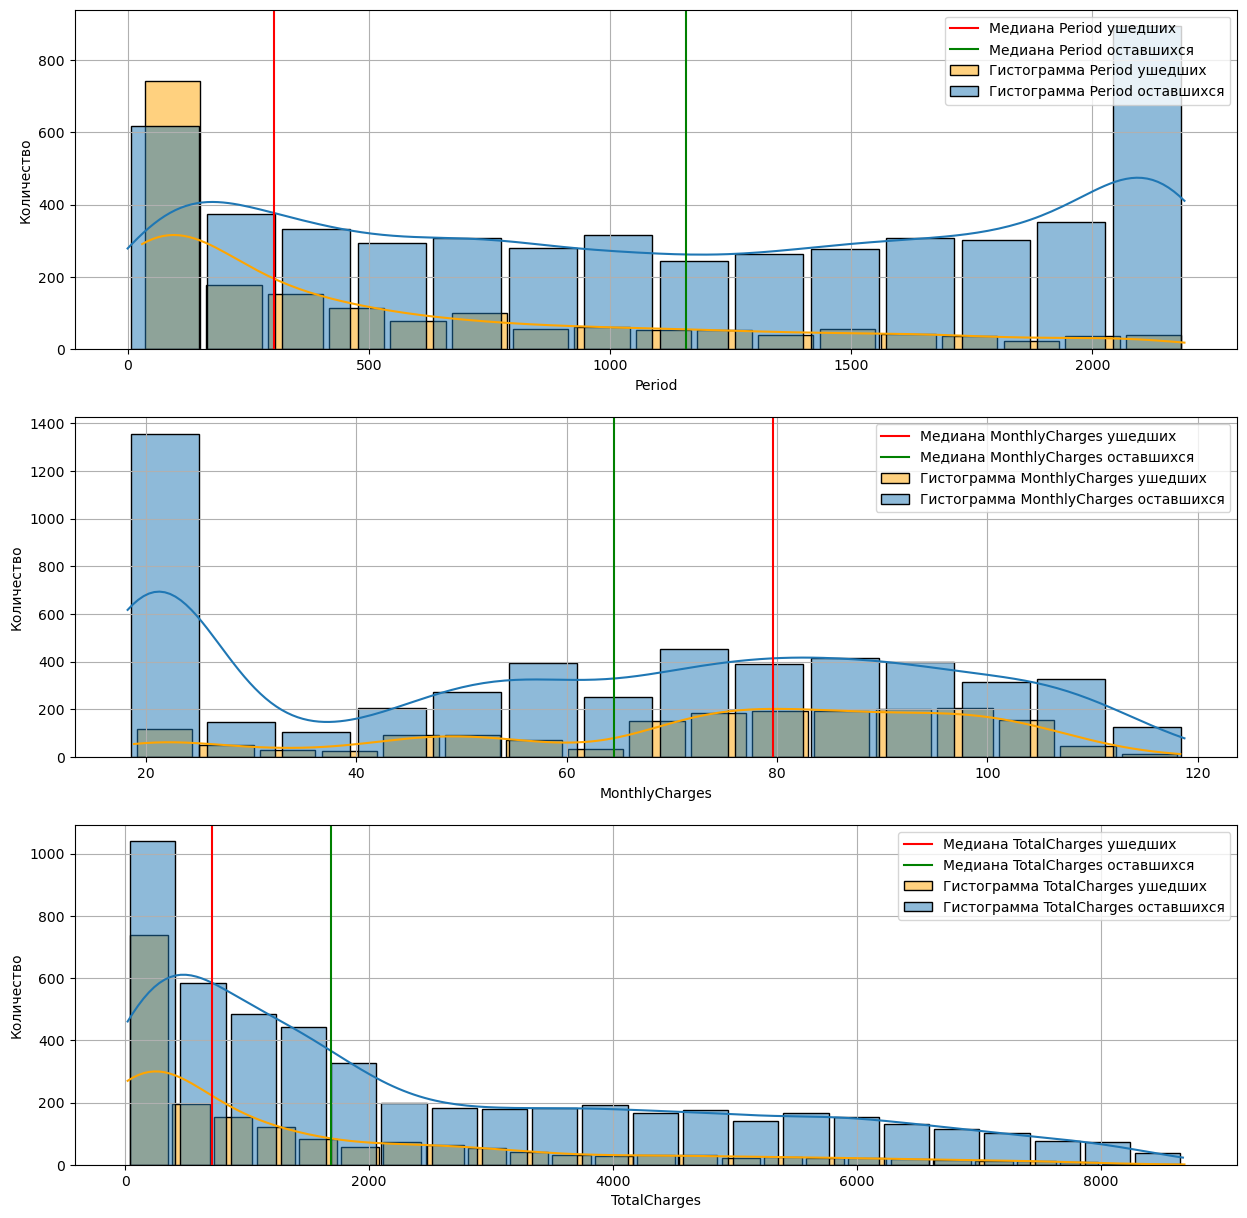

In [21]:
fig, axes = plt.subplots(len(num_cols), 1, figsize=(15, 15))
for col, i in zip(num_cols, range(len(num_cols))):
    
    sns.histplot(data.query('Churn==1')[col], 
                 kde=True, 
                 ax=axes[i], 
                 shrink=0.9,
#                  bins=17,
                 color = 'Orange',
                 label=f'Гистограмма {col} ушедших')
    sns.histplot(data.query('Churn==0')[col], 
                 kde=True, 
                 ax=axes[i], 
                 shrink=0.9, 
#                  bins=17,
                # binrange=(0, data.max().max()),
                 label=f'Гистограмма {col} оставшихся')
    axes[i].axvline(data.query('Churn==1')[col].median(), color='red', label=f'Медиана {col} ушедших')
    axes[i].axvline(data.query('Churn==0')[col].median(), color='green', label=f'Медиана {col} оставшихся')
    axes[i].set_ylabel('Количество')
    axes[i].grid()
    axes[i].legend()

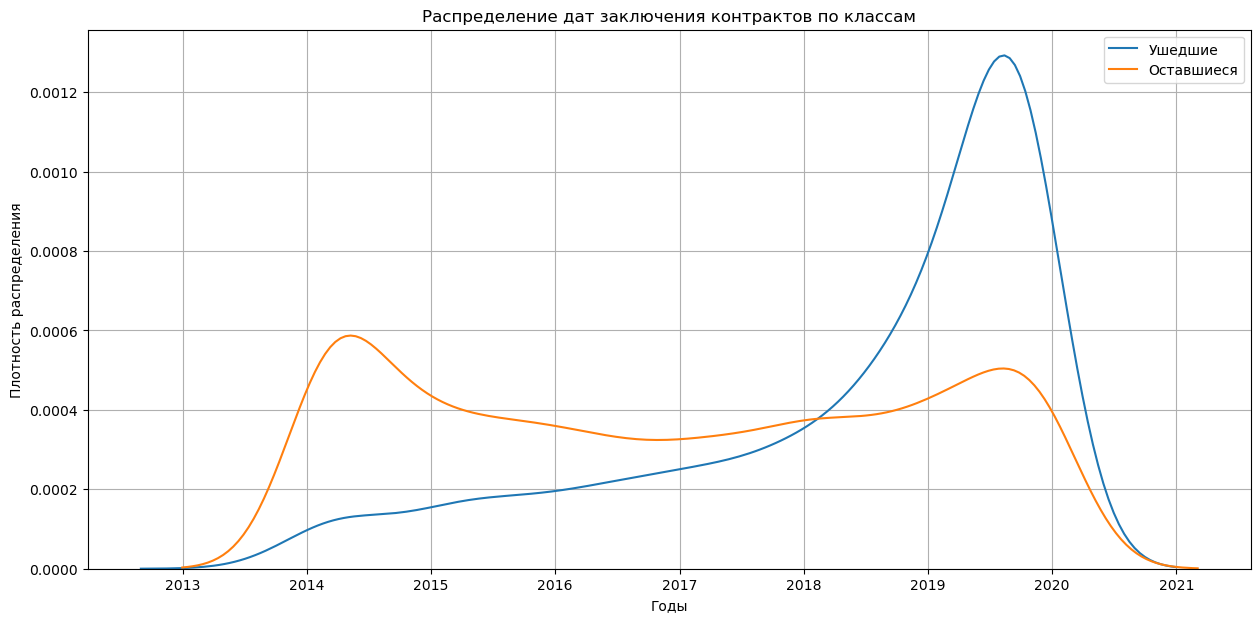

In [22]:
fig, axes = plt.subplots(figsize=(15, 7))
sns.kdeplot(data.query('Churn==1')['BeginDate'].astype('datetime64'),label='Ушедшие')
sns.kdeplot(data.query('Churn==0')['BeginDate'].astype('datetime64'),label='Оставшиеся')
axes.set_title('Распределение дат заключения контрактов по классам')
axes.set_xlabel('Годы')
axes.set_ylabel('Плотность распределения')
axes.legend()
axes.grid()

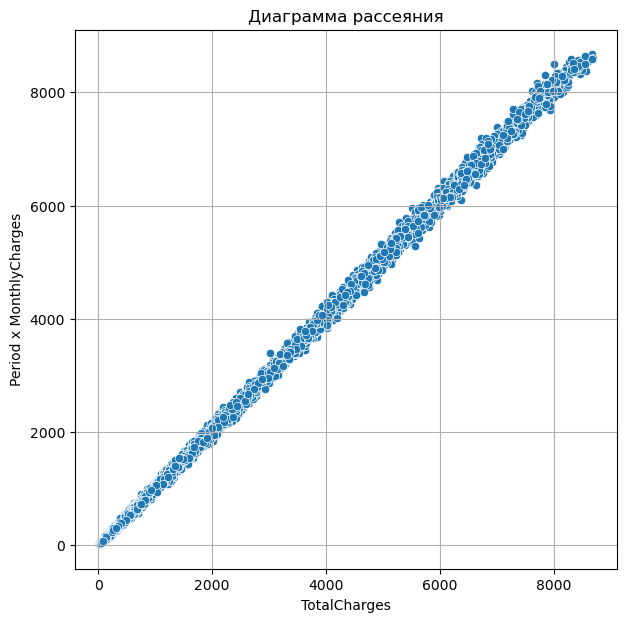

In [23]:
fig, axes = plt.subplots(figsize=(7, 7))
sns.scatterplot(data['TotalCharges'], data['Period'] /30 * data['MonthlyCharges'], )
axes.set_title('Диаграмма рассеяния')
axes.set_xlabel('TotalCharges')
axes.set_ylabel('Period x MonthlyCharges')
axes.grid()

### Корреляция Пирсона для числовых признаков

<AxesSubplot:>

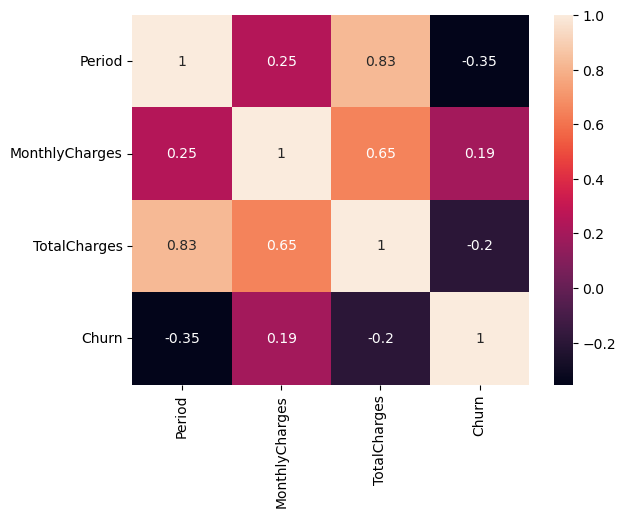

In [24]:
sns.heatmap(data[num_cols+[target_col]].corr(), annot=True)

### Корреляция Фика для категориальных признаков

interval columns not set, guessing: ['SeniorCitizen', 'Churn']


<AxesSubplot:>

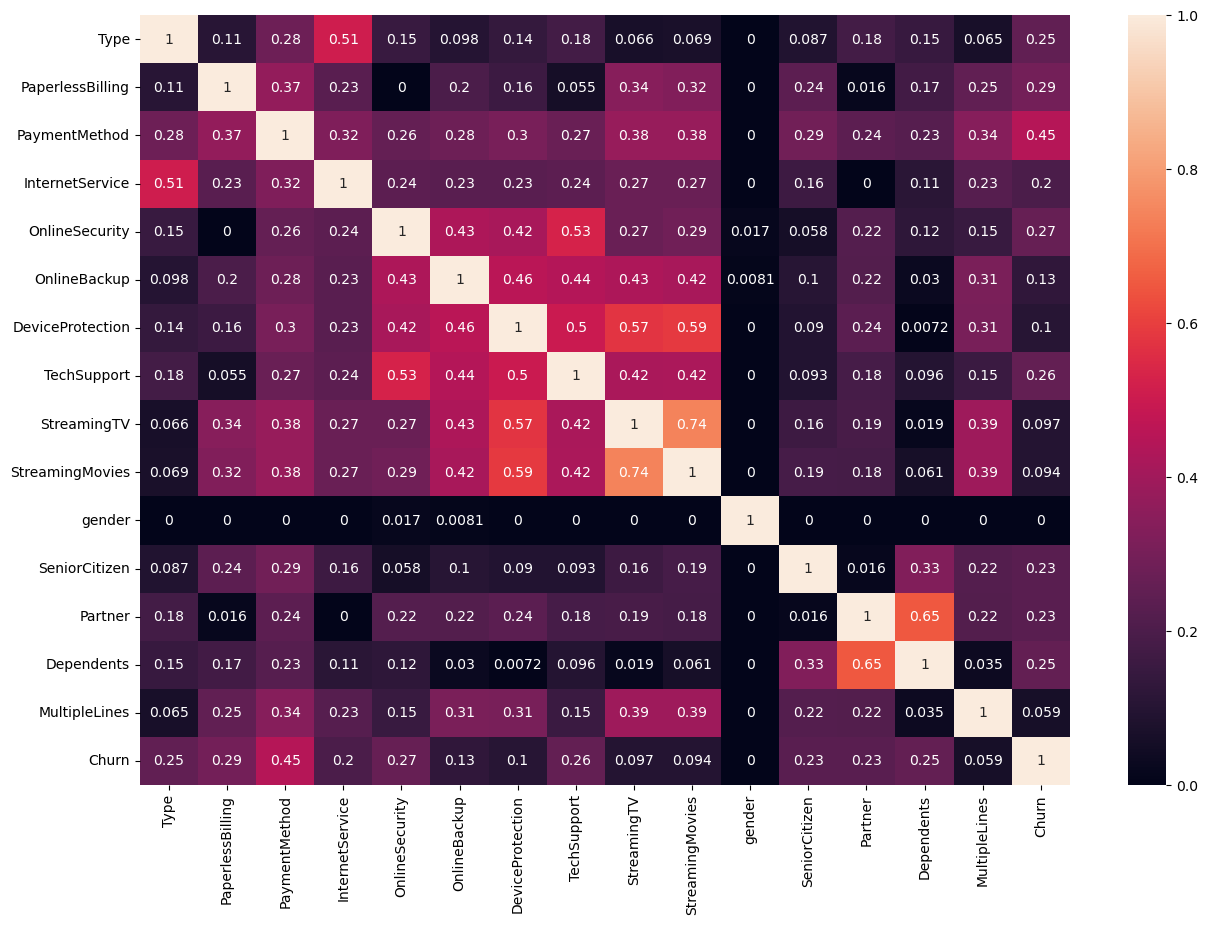

In [25]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(data[cat_cols+[target_col]].fillna('No').phik_matrix(), annot=True, ax=ax)

### Портрет уходящего клиента:
* Пользуется услугами < 1 года
* Период оплаты - от месяца к месяцу
* Способ оплаты - электронный чек
* Использование интернета без подключения большинства дополнительных услуг

## Подготовка данных
* Создадим признак с шумом.
* Составим набор фич для разных типов моделей
* Разделим выборку на обучающую и тестовую

<AxesSubplot:xlabel='Noise', ylabel='Count'>

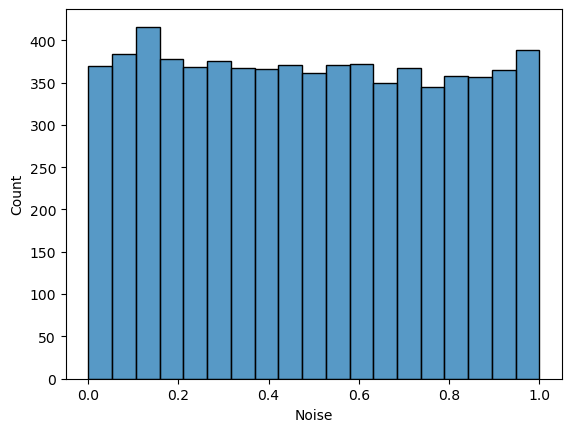

In [26]:
data = data.drop(['EndDate', 'BeginDate'], axis=1)
data['Noise'] = np.random.uniform(0,1,data.shape[0])
sns.histplot(data['Noise'])

In [27]:
num_cols_log = [
    'Period',
    'MonthlyCharges',
    # 'TotalCharges',
    'Noise'
]
cat_cols_log = [
    'Type', 
    'PaperlessBilling', 
    'PaymentMethod', 
    'InternetService', 
    'OnlineSecurity',
    'OnlineBackup', 
    'DeviceProtection', 
    'TechSupport', 
    'StreamingTV',
    # 'StreamingMovies', 
    # 'gender', 
    'SeniorCitizen', 
    'Partner', 
    'Dependents',
    'MultipleLines',
]
feature_cols_log = num_cols_log + cat_cols_log

In [28]:
num_cols = [
    'Period',
    'MonthlyCharges',
    # 'TotalCharges',
    'Noise'
]
cat_cols = [
    'Type', 
    'PaperlessBilling', 
    'PaymentMethod', 
    'InternetService', 
    'OnlineSecurity',
    'OnlineBackup', 
    'DeviceProtection', 
    'TechSupport', 
    'StreamingTV',
    'StreamingMovies', 
    # 'gender', 
    'SeniorCitizen', 
    'Partner', 
    'Dependents',
    'MultipleLines',
]
feature_cols = num_cols + cat_cols

In [29]:
X = data.drop(target_col, axis=1)
y = data[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.25, 
                                                    shuffle=True, 
                                                    stratify=data[target_col],
                                                    random_state=RANDOM_STATE
                                                   )

## Обучение моделей
Попробуем различные по типу модели:
* Логистическая регрессия
* Случайный лес
* Градиентный бустинг
* Полносвязная нейронная сеть (дополнительно).

Обучение моделей и подбор параметров будем осуществлять с применением кросс-валидации.

### Логистическая регрессия

* Пропуски в категориальных признаках заполним 'No', т.к. при выделении в отдельную категорию (как это сделано для анализа) получим сильно коррелирующие по Фику признаки.
* Подбор гиперпараметров будем осуществлять при помощи GridSearch, т.к. логистическая регресия - алгоритм "быстрый" и гиперпараметров для подбора у него меньше, чем у остальных.

In [30]:
cat_pipeline_log = Pipeline([
    ('input', SimpleImputer(strategy='constant', fill_value='No')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False, drop='if_binary')) 
     ]
    )

num_pipeline_log = Pipeline([('input', SimpleImputer(strategy='median')),
                         ('scaler', StandardScaler())])

preprocessor_log = ColumnTransformer([('cat', cat_pipeline_log, cat_cols_log),
                                 ('num', num_pipeline_log, num_cols_log)])

log_pipe = Pipeline([('preprocessor', preprocessor_log),
                     ('log_reg', LogisticRegression())])

In [31]:
params_log ={
    'log_reg__C': np.logspace(0.01, 50, 20),
    'log_reg__class_weight' : ['None', 'balanced']
}
grid_search_log = GridSearchCV(log_pipe, 
                               params_log, 
                               scoring='roc_auc', 
                               refit=True, 
                               cv=StratifiedKFold(5, shuffle=True))

In [32]:
grid_search_log.fit(X_train[feature_cols_log], y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('input',
                                                                                          SimpleImputer(fill_value='No',
                                                                                                        strategy='constant')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='if_binary',
                                                                                                        handle_unknown='ignore',
                                                                                           

In [33]:
models_score = pd.DataFrame(index=['AUC', 'Accuracy', 'F1_score'])
models_score['LogisticRegression_train'] = [grid_search_log.best_score_,
                                      accuracy_score(grid_search_log.predict(X_train), y_train),
                                      f1_score(grid_search_log.predict(X_train), y_train)]
models_score

,LogisticRegression_train
AUC,0.840175
Accuracy,0.802542
F1_score,0.592882


### Случайный лес

* Для случайного леса в силу его "тяжеловесности" попробуем подобрать параметры при помощи HyperOpt.

In [34]:
class OptHyperparams():
    
    ''' Класс для поиска гиперпараметров при помощи библиотеки HyperOpt, 
    и обучения моделей с лучшими из найденных гиперпараметрами'''
    
    def __init__ (self, 
                  estimator, 
                  space=dict(),
                  other_params=dict(), 
                  cv=5, 
                  max_evals=20, 
                  scoring='neg_log_loss'):
        
        self.estimator = estimator
        self.space=space
        self.other_params = other_params
        self.cv=cv
        self.max_evals = max_evals
        self.scoring = scoring
        self.results_ = []
        print('Создан')
        
    def __cross_val__(self, params):
        
        cross_val = cross_val_score(self.estimator(**params, **self.other_params), 
                        X=self.X, 
                        y=self.y,           
                        scoring=self.scoring,
                        cv=self.cv,
                        error_score='raise'
                       )

        result = {'loss' : -cross_val.mean(), 'status': STATUS_OK}

        print(f'Средний {self.scoring}: {cross_val.mean():.4f}')
        print(f'Стандартное отклонение по фолдам: {cross_val.std():.4f}')
        print(f'Tекущие параметры: {params}')
        self.results_.append(cross_val.mean())
        return result


    def get_best_params(self):

        best_params = fmin(self.__cross_val__, 
                           space = self.space, 
                           algo=tpe.suggest, 
                           trials=Trials(), 
                           max_evals=self.max_evals)
        
        for param_name, param_score in best_params.items():
            if param_score % 1 == 0:
                best_params[param_name] = int(param_score)
            
        print ('Лучшие гиперпараметры:', best_params)
        self.best_params = best_params
        return best_params
    
    def fit(self, X, y):
        self.X=X
        self.y=y
        self.model = self.estimator(**self.get_best_params(), **self.other_params)
        self.model.fit(X, y)
        
    def predict(self, X_pred):
        return self.model.predict(X_pred)
    
    def predict_proba(self, X_pred_prob):
        return self.model.predict_proba(X_pred_prob)
    
    def get_best_score_(self):
        return max(self.results_)

In [35]:
rfc_space={'n_estimators' : scope.int(hp.quniform('n_estimators', 50, 151, 10)), 
           'max_depth' : scope.int(hp.quniform('max_depth', 2, 11, 1))}

In [36]:
cat_pipeline = Pipeline([
    ('input', SimpleImputer(strategy='constant', fill_value='No')),
    ('ohe', OrdinalEncoder())])

num_pipeline = Pipeline([('input', SimpleImputer(strategy='median'))])

preprocessor = ColumnTransformer([('cat', cat_pipeline, cat_cols),
                                 ('num', num_pipeline, num_cols)])

rfc_pipe = Pipeline([('preprocessor', preprocessor),
                     ('rfc', OptHyperparams(RandomForestClassifier, 
                       space=rfc_space, 
                       scoring='roc_auc',
                       cv=StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE),
                       max_evals=20))])

Создан


In [37]:
rfc_pipe.fit(X_train, y_train)

Средний roc_auc: 0.8520                               
Стандартное отклонение по фолдам: 0.0140              
Tекущие параметры: {'max_depth': 4, 'n_estimators': 120}
Средний roc_auc: 0.8557                                                          
Стандартное отклонение по фолдам: 0.0127                                         
Tекущие параметры: {'max_depth': 5, 'n_estimators': 130}                         
Средний roc_auc: 0.8574                                                          
Стандартное отклонение по фолдам: 0.0111                                        
Tекущие параметры: {'max_depth': 7, 'n_estimators': 90}                         
Средний roc_auc: 0.8538                                                          
Стандартное отклонение по фолдам: 0.0126                                         
Tекущие параметры: {'max_depth': 4, 'n_estimators': 140}                         
Средний roc_auc: 0.8557                                                          
Стандартное отк

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('input',
                                                                   SimpleImputer(fill_value='No',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OrdinalEncoder())]),
                                                  ['Type', 'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                              

In [38]:
models_score['RandomForrest_train'] = [rfc_pipe['rfc'].get_best_score_(),
                                 accuracy_score(rfc_pipe.predict(X_train), y_train),
                                 f1_score(rfc_pipe.predict(X_train), y_train)]
models_score

,LogisticRegression_train,RandomForrest_train
AUC,0.840175,0.857470
Accuracy,0.802542,0.823786
F1_score,0.592882,0.596262


### Градиентный бустинг

* В качестве модели градиентного бустинга будем использовать CatBoost.
* Для подбора гиперпараметров с кросвалидацией, заполнение пропусков в числовых признаках, будем использовать стандартные средства библиотеки CatBoost.
* Выполним заполнение пропусков для категорильных переменных.

In [39]:
X_train[cat_cols] = X_train[cat_cols].fillna('No')
X_test[cat_cols] = X_test[cat_cols].fillna('No')

In [40]:
X_train_cb = X_train[feature_cols]
X_test_cb = X_test[feature_cols]

In [41]:
params_catboost = {'n_estimators':range(700,801,100),
                   'max_depth' : [2],
                   'learning_rate': np.linspace(0.3, 0.5, 3)
                  }

catboost_clf = CatBoostClassifier(eval_metric='AUC',
                                  auto_class_weights='Balanced',
#                                   class_weights=[1, 3], 
                                  cat_features=cat_cols, 
                                  random_state=RANDOM_STATE, 
                                  nan_mode = 'Max',
                                  logging_level='Silent')

catboost_grid = catboost_clf.grid_search(params_catboost, 
                                         X_train_cb, 
                                         y_train, 
                                         cv=StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE), 
                                         partition_random_seed=RANDOM_STATE, 
                                         calc_cv_statistics=True,
                                         search_by_train_test_split=False,
                                         verbose=False,
                                         refit=True,
                                         plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.


In [42]:
models_score['Catboost_train'] = [max(catboost_grid['cv_results']['test-AUC-mean']),
                                 accuracy_score(catboost_clf.predict(X_train_cb), y_train),
                                 f1_score(catboost_clf.predict(X_train_cb), y_train)]
models_score

,LogisticRegression_train,RandomForrest_train,Catboost_train
AUC,0.840175,0.857470,0.928059
Accuracy,0.802542,0.823786,0.923369
F1_score,0.592882,0.596262,0.865781


* В качестве лучшей модели была выбрана модель на основе CatboostClassifier. Все основные метрики значительно лучше, чем у остальных моделей

### Полносвязная нейронная сеть

In [43]:
preprocessor_nn = ColumnTransformer([('cat', cat_pipeline_log, cat_cols),
                                 ('num', num_pipeline_log, num_cols)])

In [44]:
X_train_nn = preprocessor_nn.fit_transform(X_train)
X_test_nn = preprocessor_nn.transform(X_test)

In [45]:
X_train_nn.shape

(5272, 24)

In [46]:
num_inputs=X_train_nn.shape[1]
num_outputs=1
num_layers=2
num_neurons=[]
for i in range(num_layers):
    num_neurons.append(24-i*6)
learning_rate=0.1
n_epochs=200
batch_size=X_train_nn.shape[0]

In [47]:
nn=Sequential()

for i in range(len(num_neurons)):
    nn.add(Dense(units=num_neurons[i],activation='relu',input_shape=(num_inputs,)))
    
nn.add(Dense(units=num_outputs,activation='sigmoid'))

nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                600       
                                                                 
 dense_1 (Dense)             (None, 18)                450       
                                                                 
 dense_2 (Dense)             (None, 1)                 19        
                                                                 
Total params: 1,069
Trainable params: 1,069
Non-trainable params: 0
_________________________________________________________________


In [48]:
nn.compile(loss=losses.binary_crossentropy, 
           optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
           metrics=['accuracy', 'AUC'])

nn.fit(X_train_nn, y_train, batch_size=batch_size, epochs=n_epochs, verbose=0, use_multiprocessing=True)

In [49]:
roc_auc_score(y_train, nn.predict(X_train_nn))

165/165 [==============================] - 0s 826us/step


0.8781163447684129

In [50]:
roc_auc_score(y_test, nn.predict(X_test_nn))

55/55 [==============================] - 0s 866us/step


0.815950319872217

<div class="alert alert-success">
<h2> Комментарий тимлида <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> хорошо

## Тестирование модели и анализ важности признаков
### Тест лучшей модели


In [51]:
best_model = catboost_clf

In [52]:
models_score['Best_model_test'] = [roc_auc_score(y_test, best_model.predict_proba(X_test[feature_cols])[:,1]),
                                 accuracy_score(best_model.predict(X_test[feature_cols]), y_test),
                                 f1_score(best_model.predict(X_test[feature_cols]), y_test)]
models_score

,LogisticRegression_train,RandomForrest_train,Catboost_train,Best_model_test
AUC,0.840175,0.857470,0.928059,0.929203
Accuracy,0.802542,0.823786,0.923369,0.866325
F1_score,0.592882,0.596262,0.865781,0.763343


<div class="alert alert-success">
<h2> Комментарий тимлида <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> тестирование -верно

**Целевая метрика достигнута!**

### Анализ важности признаков

In [53]:
pd.DataFrame(best_model.feature_importances_, 
             best_model.feature_names_, 
             columns = ['Важность']
            ).sort_values(by='Важность', ascending=False).style.bar()

,Важность
Period,70.618719
MonthlyCharges,8.160132
Noise,7.412118
Type,6.314161
InternetService,3.234810
PaymentMethod,1.240933
PaperlessBilling,0.398954
TechSupport,0.394627
StreamingMovies,0.369870
OnlineSecurity,0.367447


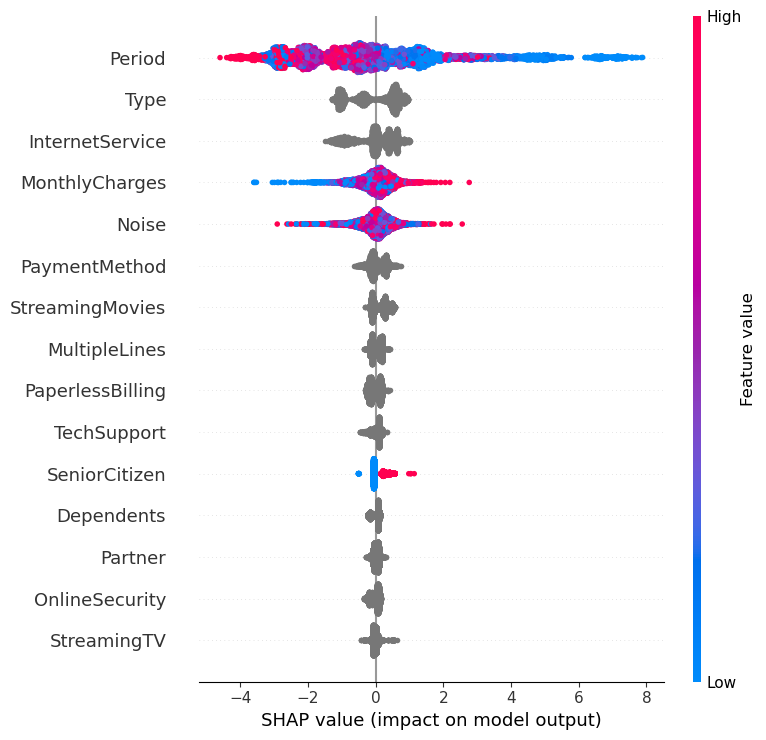

In [54]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train_cb)
shap.summary_plot(shap_values , X_train_cb, max_display=15)

* Период использования услуг - доминирующий признак.
* Ниже порога почти все категориальные признаки.

In [55]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train_cb.iloc[0,:])

### Финальная модель
* Исключаем из набора признаки не прошедшие порог и тестируем лучшую модель на этих данных

In [56]:
num_cols_final = [
    'Period',
    'MonthlyCharges',
    # 'TotalCharges',
    # 'Noise'
]
cat_cols_final = [
    'Type', 
    # 'PaperlessBilling', 
    # 'PaymentMethod', 
    'InternetService', 
    # 'OnlineSecurity',
    # 'OnlineBackup', 
    # 'DeviceProtection', 
    # 'TechSupport', 
    # 'StreamingTV',
    # 'StreamingMovies', 
    # 'gender', 
    # 'SeniorCitizen', 
    # 'Partner', 
    # 'Dependents',
    # 'MultipleLines',
]
feature_cols_final= num_cols_final + cat_cols_final

In [57]:
catboost_clf_best = CatBoostClassifier(n_estimators=700,
                                  max_depth=2,
                                  learning_rate=0.5,
                                  eval_metric='AUC',
                                  cat_features=cat_cols_final, 
                                  random_state=RANDOM_STATE, 
                                  nan_mode = 'Max',
                                  verbose=False)

In [58]:
catboost_clf_best.fit(X_train[feature_cols_final], y_train, plot=True, eval_set=(X_test[feature_cols_final], y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [59]:
models_score['Final_metrics'] = [roc_auc_score(y_test, catboost_clf_best.predict_proba(X_test[feature_cols_final])[:,1]),
                                 accuracy_score(catboost_clf_best.predict(X_test[feature_cols_final]), y_test),
                                 f1_score(catboost_clf_best.predict(X_test[feature_cols_final]), y_test)]
models_score

,LogisticRegression_train,RandomForrest_train,Catboost_train,Best_model_test,Final_metrics
AUC,0.840175,0.857470,0.928059,0.929203,0.942040
Accuracy,0.802542,0.823786,0.923369,0.866325,0.891923
F1_score,0.592882,0.596262,0.865781,0.763343,0.772182


**После удаления малозначимых признаков, значительно увеличилась скорость, а метрика даже немного улучшилась!**

* Посмотрим на финальные метрики

In [60]:
fpr_test, tpr_test, _ = roc_curve(y_test, catboost_clf_best.predict_proba(X_test[feature_cols_final])[:,1])
fpr_train, tpr_train, _ = roc_curve(y_train, catboost_clf_best.predict_proba(X_train[feature_cols_final])[:,1])

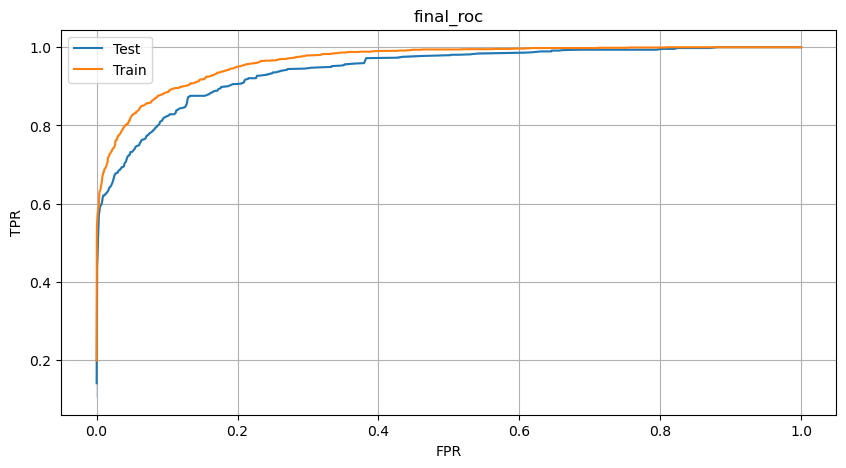

In [61]:
fig, axes = plt.subplots(figsize=(10, 5))
sns.lineplot(x=fpr_test, y=tpr_test, label='Test')
sns.lineplot(x=fpr_train, y=tpr_train, label='Train')
axes.set_title('final_roc')
axes.set_xlabel('FPR')
axes.set_ylabel('TPR')
axes.legend()
axes.grid()
# plt.savefig('roc.png')

Text(0.5, 3.722222222222216, 'Predicted label')

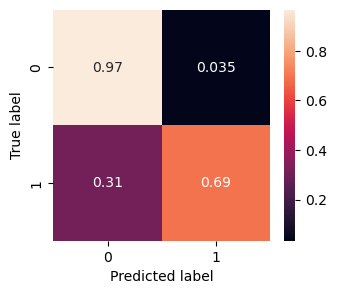

In [62]:
plt.figure(figsize=(3.5,3))
cm = confusion_matrix(y_test, 
                      catboost_clf_best.predict(X_test[feature_cols_final]), 
                      normalize='true')
sns.heatmap(cm, annot=True)
plt.ylabel('True label')
plt.xlabel('Predicted label')
# plt.savefig('confusion_matrix.png')

## Отчет

**ВЫПОЛНЕНЫЕ ШАГИ**
1. ***Загрузка и анализ данных:***
* Таблицы изучены и объеденены в единый датасет
* Пропуски, образовавшиеся при заполнении признаков для исследовательского анализа заполнены новой категорией "No_package"
* Исключены явные дубликаты
* Удалены признаки дат, добавлена целевая метка факта ухода и признак период пользования услугами `period`.
* Исследована зависимости признаков от целевого признака - факта ухода клиента
* Обнаружена небалансированность классов ~1/3.
* Выявленны мультиколлинеарные признаки: 
    * числовые признаки `TotalCharges` и `MonthlyCharges`
    * категориальные признаки `StreamingMovies` и `StreamingTV`
* Выявлен малозначимый признак `gender`
* Составлен портрет уходящего клиента.

2. ***Подготовка данных:***

* Для определения порога важности признаков (выполнение рекурентного отбора признаков) был добавлен признак `Noise` состоящий из "шума".
* Составлен набор признаков для обучения моделей. Для всех моделей был исключен признак `TotalCharges` как один из мультиколлинерных признаков (важно для логистической регресии), а также как практически полностью определенный признаками `Period` и  `MonthlyCharges` (не несет дополнительной информации для всех остальных моделей). Для логистической регресии также были исключены признак `StreamingMovies` как существенно коррелирующий с `StreamingTV`.
* Выборка поделена на обучающую и тестовую с применение стратификации и с размером тестовой выборки в 25%.

3. ***Обучение моделей***:
* Все интерпретируемые модели были обучены с примененением кроссвалидации и подбором гиперпараметров (наиболее важных для конкретного типа модели)
* Для логистической регрессии был выстроен pipeline отдельной обработкой категориальных и числовых признаков. 
     * Пропуски в категориальных признаках заполнялись значением "No".
     * Кодирование категориальных признаков производилось методом OHE в случае наличия более 2 категорий и LE в случае наличия 2 категорий в признаке (параметр drop='if_binary').
     * Числовые признаки были масштабированы при помощи StandartScaler $ {z} = {x - μ  \over  σ}$
     * Подбор гиперпараметров ***C*** и ***class_weight*** осуществлялся при помощи перебора по сетке (GridSearch).
* Для модели случайного леса (RandomForrestClassifier библиотеки sklearn) был выстроен похожий pipeline.
    * Пропуски в категориальных признаках заполнялись значением "No".
    * Кодирование категориальных признаков производилось методом OrdinalEncoder.
    * Подбор гиперпараметров ***max_depth*** и ***n_estimators*** осуществлялся при помощи Байесовской оптимизации (HyperOpt)
* Построение модели на основе градиентного бустинга (CatboostClassifier) была выполнена следующим образом:
    * Пропуски в категориальных признаках заполнялись значением "No".
    * Кодирование категориальных признаков и подбор гиперпараметров ***max_depth***,  ***n_estimators***, ***learning_rate*** были осуществлены при помощи внутренних методов библиотеки CatBoost.
* Также для сравнения была построена небольшая полносвязная нейронная сеть на основе готовых слоев из TensorFlow.Keras. При ручном переборе параметров не удалось превысить метрику лучшей интрпретируемой модели, поэтому в дальнейшем эту модель рассматривать не будем.

4. ***Тестирование модели и анализ важности признаков*** 
* Получили предсказание и метрику лучшей модели на тестовых данных
* Для оценки важности признаков была использована сводная диаграмма значений Шепли (SHAP)
* Исключены признаки не прошедшие шумовой порог
* Построена и протестирована финальная модель

**ОТКЛОНЕНИЯ ОТ ПЛАНА**
* План был выполненен в полном объеме без существенных отклонений

**ТРУДНОСТИ**
* Изначально метод назначения весов классов для борьбы с их дисбалансом в Catboost был добавлен в подбор гиперпараметров. Отбор осуществлялся на по метрике AUC, не чувствительной к дисбалансу. В результате был выбран вариант с отсутствием поправки по весам, в следствие чего на тестовой выборке сильно просели метрики Accuracy и F-меры при незначительном изменении AUC. Параметр ***auto_class_weight*** был зафиксирован, после чего метрики Accuracy и F-меры уже не так значительно упали на тесте. Этот фактор стоило учемть зараянее.

**ПОЛУЧЕННЫЕ РЕЗУЛЬТАТЫ**
1. Портрет уходящего клиента:
    * Пользуется услугами < 1 года
    * Период оплаты - от месяца к месяцу
    * Способ оплаты - электронный чек
    * Использование интернета без подключения большинства дополнительных услуг.
    
2. Важность признаков:
* Было выявлено, что главным признаком с большим отрывом является созданный нами "период использования услуг" `period`, чем он выше, тем меньше вероятность ухода клиента
* Если в наборе оставить один этот признак, то AUC уже превышает заданный порог в 0.85

3. Выбор модели по результатам кроссвалидации с подбором гиперпараметров:
* Метрики моделей: 

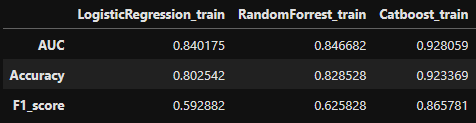

* По итогам анализа моделей и полученных на обучающей выборке метрик была выбрана модель *CatboostClassifier*

4. Финальная модель:
* Модель основанная на градиентном бустинге *CatboostClassifier гиперпараметрами:
     * ***max_depth*** = 2  
     * ***n_estimators***= 700 
     * ***learning_rate*** =0.5
* Отоборанные для финальной модели признаки:
    * `Period`
    * `MonthlyCharges`
    * `Type`
    * `InternetService`
* Метрики полученные на отобранных признаках:
     * AUC = 0.942
     * Accuracy = 0.892
     * F1-мера = 0.772
     * TN = 0.97
     * TP = 0.69
* Несмотря на то, что Accuracy(наиболее понятная для заказчика метрика) довольно неплохая ~89%, модель довольно часто ошибается принимая клиента, который уйдет, за того кто останется.  
